# Classification of around 200k (here smaller portion of it: ~20k) abstracts from PubMed. Each sentence in these abstracts are classified into either of the following: 'OBJECTIVE', 'METHODS', 'RESULTS', 'CONCLUSIONS', 'BACKGROUND'

## Traditional ML modeling approach
First, we utilize the traditional approach, using the well-known `scikit-learn` package and `MultinomialNB` (Multinomial Naive Bayes) model. MultinomialNB is chosen as the starting point because - 
 - simple to implement
 - fast to train
 - often works well with sparse data
 - has been used in similar NLP tasks (classification of text data)

In [28]:
#Imports
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting
import seaborn as sns #plotting
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

To read a file directly from *GitHub* using `pandas.read_csv()`, use either of these two methods:
 - [Method 1](https://stackoverflow.com/a/63102455): Append `?raw=true` to the URL
 - [Method 2](https://stackoverflow.com/a/64119026): 
    - Remove `blob`, 
    - Replace `github.com` by `raw.githubusercontent.com`

In [3]:
#Load the 20k train data
# df = pd.read_csv('https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT/train.txt')
# df = pd.read_csv('https://github.com/Franck-Dernoncourt/pubmed-rct/blob/master/PubMed_20k_RCT/train.txt')

df = pd.read_csv(
    'https://github.com/Franck-Dernoncourt/pubmed-rct/blob/865e02d522bbb0f854e2b422f64446d646d46007/PubMed_20k_RCT/train.txt?raw=true'
                , sep="\t", header=None, names=["label", "text"])
print(df.head(n = 26), "\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195040 entries, 0 to 195039
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   195040 non-null  object
 1   text    180040 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB
          label                                               text
0   ###24293578                                                NaN
1     OBJECTIVE  To investigate the efficacy of 6 weeks of dail...
2       METHODS  A total of 125 patients with primary knee OA w...
3       METHODS  Outcome measures included pain reduction and i...
4       METHODS  Pain was assessed using the visual analog pain...
5       METHODS  Secondary outcome measures included the Wester...
6       METHODS  Serum levels of interleukin 1 ( IL-1 ) , IL-6 ...
7       RESULTS  There was a clinically relevant reduction in t...
8       RESULTS  The mean difference between treatment arms ( 9...
9       RESULTS  Further , there

Similarly done for the test data.

In [10]:
#Load the 20k test data 
df_test = pd.read_csv(
    'https://github.com/Franck-Dernoncourt/pubmed-rct/blob/865e02d522bbb0f854e2b422f64446d646d46007/PubMed_20k_RCT/test.txt?raw=true'
    , sep="\t", header=None, names=["label", "text"])
df_test.dropna(inplace=True)
print(df_test.head(n = 26), "\n", df_test.info())

# Get rid of the NaN rows from the training `df` also:
df = df.dropna()

<class 'pandas.core.frame.DataFrame'>
Index: 30135 entries, 1 to 32634
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   30135 non-null  object
 1   text    30135 non-null  object
dtypes: object(2)
memory usage: 706.3+ KB
          label                                               text
1    BACKGROUND  This study analyzed liver function abnormaliti...
2       RESULTS  A post hoc analysis was conducted with the use...
3       RESULTS  Liver function tests ( LFTs ) were measured at...
4       RESULTS  Survival analyses were used to assess the asso...
5       RESULTS  The percentage of patients with abnormal LFTs ...
6       RESULTS  When mean hemodynamic profiles were compared i...
7       RESULTS  Multivariable analyses revealed that patients ...
8   CONCLUSIONS  Abnormal LFTs are common in the ADHF populatio...
9   CONCLUSIONS  Elevated MELD-XI scores are associated with po...
11   BACKGROUND  Minimally invasive endov

## Data exploration using `pandas` 

In [18]:
# count of particular label in the datasets
print(df['label'].value_counts(), df_test['label'].value_counts())

label
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64 label
METHODS        9897
RESULTS        9713
CONCLUSIONS    4571
BACKGROUND     3621
OBJECTIVE      2333
Name: count, dtype: int64


In [19]:
# average length of sentences
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
average_sentence_length = df['text_length'].mean()
print("Average sentence length:", average_sentence_length)

Average sentence length: 26.338435903132638


In [23]:
# longest or shortest sentences
longest_train = df.loc[df['text_length'].idxmax(), 'text']
print("Longest sentence in train:", longest_train)

df_test['text_length'] = df_test['text'].apply(
    lambda x: len(x.split()))
longest_test = df_test.loc[df_test['text_length'].idxmax(), 'text']
print("Longest sentence in test:", longest_test)

Longest sentence in train: Patients in the antegrade group achieved better outcomes than patients in the retrograde group for all clinical parameters at 3 months postoperatively ( ROM : antegrade median 80 [ range , 57-90 ] versus retrograde 69 [ range , 45-90 ] , difference of medians 11 , p < 0.001 ; VAS : antegrade median of 2 [ range , 0-5 ] versus retrograde 4 [ range , 0-7 ] , difference of medians 2 , p < 0.001 ; grip strength : antegrade median 81 % [ range , 60 % -100 % ] versus retrograde 71 % [ range , 49 % -98 % ] , differences of medians 10 % , p < 0.001 ; DASH : antegrade median 4.3 [ range , 0-15 .8 ] versus retrograde 10.3 [ range , 0-28 .4 ] , difference of medians 6 , p < 0.001 ) , but these differences , with the numbers available , were not observed at 6 months postoperatively for any clinical parameters ( ROM : antegrade median 88 [ range , 81-90 ] versus retrograde 87 [ range , 80-90 ] , difference of medians 1 , p = 0.35 ; VAS : antegrade median 1 [ range , 0-2 ]

Knowing the longest word count would be very useful in deciding the maximum length of the padded sequences (particulary in deep learning). We use the `re` package to count the number of words (including special characters that will be special tokens when tokenizing) in each sentence.

In [25]:
import re

def count_words_with_special_characters(text):
    return len(re.findall(r'\S+', text))

df['text_length_with_special_chars'] = df['text'].apply(
    count_words_with_special_characters)

longest_sentence_with_special_chars = df.loc[df[
    'text_length_with_special_chars'].idxmax(), 'text']
longest_sentence_word_count_with_special_chars = df[
    'text_length_with_special_chars'].max()
print("Longest sentence:", longest_sentence_with_special_chars)
print("Word count with special characters:", 
    longest_sentence_word_count_with_special_chars)

Longest sentence: Patients in the antegrade group achieved better outcomes than patients in the retrograde group for all clinical parameters at 3 months postoperatively ( ROM : antegrade median 80 [ range , 57-90 ] versus retrograde 69 [ range , 45-90 ] , difference of medians 11 , p < 0.001 ; VAS : antegrade median of 2 [ range , 0-5 ] versus retrograde 4 [ range , 0-7 ] , difference of medians 2 , p < 0.001 ; grip strength : antegrade median 81 % [ range , 60 % -100 % ] versus retrograde 71 % [ range , 49 % -98 % ] , differences of medians 10 % , p < 0.001 ; DASH : antegrade median 4.3 [ range , 0-15 .8 ] versus retrograde 10.3 [ range , 0-28 .4 ] , difference of medians 6 , p < 0.001 ) , but these differences , with the numbers available , were not observed at 6 months postoperatively for any clinical parameters ( ROM : antegrade median 88 [ range , 81-90 ] versus retrograde 87 [ range , 80-90 ] , difference of medians 1 , p = 0.35 ; VAS : antegrade median 1 [ range , 0-2 ] versus r

We can make it easier to understand the dataset, using some graphs as well. We use `pandas` and `seaborn` for this purpose.

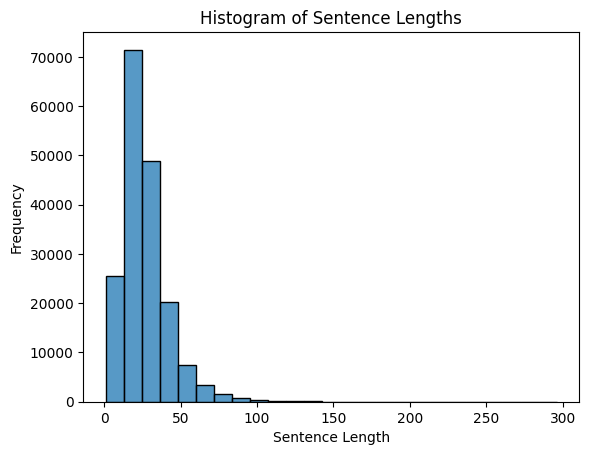

In [31]:
# sentence length distribution
sns.histplot(data=df, x='text_length', bins=25)
plt.title('Histogram of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

Clearly, the distribution of the number of words in each sentence is right-skewed. This is expected, as most of the sentences are short, and only a few are long. The longest sentence is just below 300 words (296 words, as counted before).

Next, we count the number of sentences in each class, and plot it as a bar graph. This is done for both the training and test data. We can see that the number of sentences in each class is not equal. This is expected, as the number of sentences in each class is dependent on the number of sentences in each abstract, and the number of abstracts in each class. The uneuqal distribution of the number of sentences in each class is also a reason why we should use the *macro* average (`F1-Macro`) as the evaluation metric, instead of the *micro* average (`F1-Micro` or `accuracy`). 

Also the similarity of the distribution of the number of sentences in each class in the training and test data is a good sign, as it means that the test data is sample well from the training data.

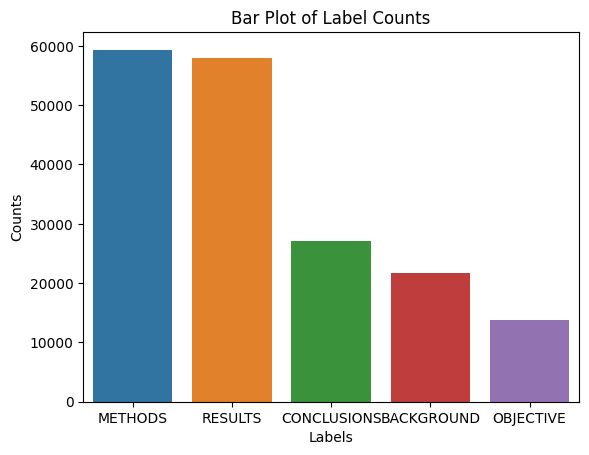

In [32]:
# Label counts barplot
label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']
sns.barplot(data=label_counts, x='label', y='count')
plt.title('Bar Plot of Label Counts')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

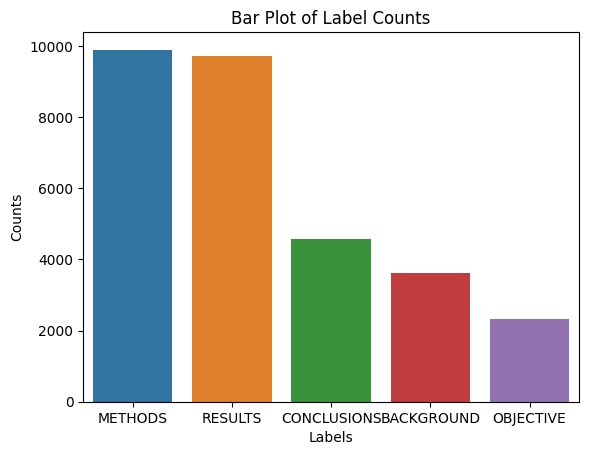

In [34]:
# Label counts barplot
label_counts = df_test['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']
sns.barplot(data=label_counts, x='label', y='count')
plt.title('Bar Plot of Label Counts')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

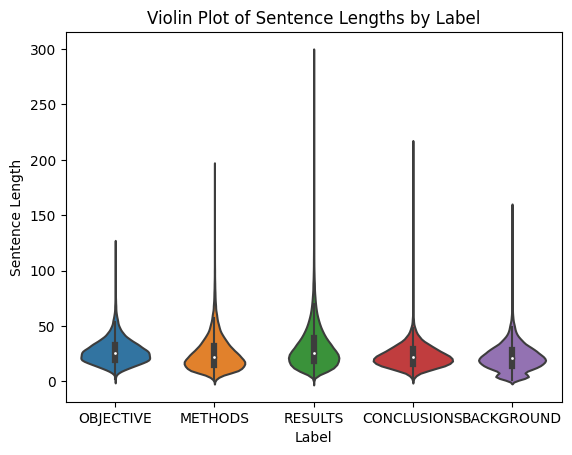

In [38]:
sns.violinplot(data=df, x='label', y='text_length')
plt.title('Violin Plot of Sentence Lengths by Label')
plt.xlabel('Label')
plt.ylabel('Sentence Length')
plt.show()

Lastly, we can see the distribution of sentence length per each label using a violinplot. This is done for the training data only. The median sentence length is around 20 words for all the labels. The longest sentence is around 300 words, and the shortest sentence is around 2 words. The distribution of sentence length is similar for all the labels, right-skewed.

Splitting the data into train and test sets. 

In [11]:
X_train, y_train = df["text"].tolist(), df["label"].tolist()
X_test, y_test = df_test["text"].tolist(), df_test["label"].tolist()

Now, we have the sentences (`X`) and their corresponding labels (`y`) with training and test split. We need to convert them into numbers for modeling. This is known as **Vectorization** in NLP (more generally, **Feature Engineering** for a particular task). We use the `CountVectorizer` class from `scikit-learn` for this purpose. 

In [12]:
# Feature engineering
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [13]:
# Train a model
MNB = MultinomialNB()
MNB.fit(X_train_vec, y_train)

MultinomialNB()

In [14]:
# Evaluate the model
print('Accuracy:', MNB.score(X_test_vec, y_test))

Accuracy: 0.7702339472374315


The accuracy is ~77% which is not bad for a baseline model and without any data augmentation.
Now, we can use our deep learning models to see if we can improve the accuracy. 

## Deep Learning (DL) Modeling approach
We will use the following framework and models: **PyTorch**, **HuggingFace Transformers**, **BERT**

Pytorch is used as the deep learning framework, and BERT is used as the model. BERT is chosen because - 
 - it is a SOTA (state-of-the-art) model
 - it is a pre-trained model, and hence, we can use transfer learning (considerably less compute time and resources)
 - it is a transformer-based model, and hence, it can be used for this multilabel sequence classification task.

The code is in google colab, as it is easier to use GPU for training the model. The code is in the following notebook: [PubMed_20k_RCT.ipynb](https://colab.research.google.com/drive/1NQwY030tB9QApbxifA-mc6FJNx5MKxkB?usp=share_link)

  - 200k is not used, cause I haven't been able to make TPU work with it and with GPU, even the 10 times less sized *20k dataset takes over one hour for only one epoch*!

  ![](Colab.png)

  - However, 200k is likely to yield better scores than 20k, as it has more data for training.
  - puttting the code in `.ipynb` & running in a *M1 Mac* leads to errors, which can originate from 
    - [multiprocessing issues](https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror?r=Saves_AllUserSaves)
    -  M1 GPU issues (`mps`) etc.
  - Given the short amount of time, I also haven't been able to delve deeper into performace metrices & performance improvemnts.
  - I used transfer learning (full BERT traning is not possible & not worth) & used the `bert-base-uncased` model, which is a smaller version of the original BERT model.


# Other possible approaches
  - Perform **additional preprocessing**, such as removing stop words, stemming, or lemmatization, to improve the quality of the input features, in traditional ML modeling.
  - Experiment with **different feature engineering techniques**, such as n-grams, character-level representations, and pretrained word embeddings (e.g., Word2Vec, GloVe), in traditional ML modeling.
  - Use **other traditional ML models**, such as SVM, Random Forest, etc.
  - Use **other DL models**, such as LSTM, CNN, etc. (although BERT is likely to perform better than these models)
  - Use **other pre-trained DL models**, such as BioBERT, SciBERT, etc.
  - Use `tensorboard` for **performace improvement** & **better visualization** of the training process (plotting, hyperparameter optimization etc.), compared to the basic `tqdm`. This, however needs more time to run, as it needs to be run locally, and not on Google Colab.
